In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import multiprocessing
import os
import numpy as np
import cv2
import shutil
import pickle
from google.colab.patches import cv2_imshow

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Train directory
os.chdir("/content/drive/My Drive/Colab Notebooks/train")
images_directory = "/content/drive/My Drive/Colab Notebooks/new"

# Results directory
result_directory = "/content/drive/My Drive/Colab Notebooks/results"

# Model path
model_path = result_directory + "/models.pickle"

# Pictures to check
check_path = "/content/drive/My Drive/Colab Notebooks/check"


# Free if exists
if os.path.isdir(result_directory):
  shutil.rmtree(result_directory)

# Create directory and change to
os.mkdir(result_directory)
os.chdir(result_directory)

image_size = 127
n = 128

# Number of reference models in each class
reference_model_count = 15

print("Текущая деректория:", os.getcwd())

Текущая деректория: /content/drive/My Drive/Colab Notebooks/results


In [ ]:
def distant(image_1, image_2):
  distant = 0.0
  for i in range(image_size):
    for j in range(image_size):
      distant += abs(image_1[i][j] - image_2[i][j])
  return distant ** 0.5

def get_up(threshed):
  color = threshed[0][0]
  for i in range(len(threshed)):
    for j in range(len(threshed[0])):      
      if (np.sum(threshed[i][j]) != color):
        return i

def get_down(threshed):
  color = threshed[0][0]
  for i in reversed(range(len(threshed))):
    for j in range(len(threshed[0])):  
      if (np.sum(threshed[i][j]) != color):
        return i

def get_left(threshed):
  color = threshed[0][0]
  for i in range(len(threshed[0])):
    for j in range(len(threshed)):  
      if (np.sum(threshed[j][i]) != color):
        return i

def get_right(threshed):
  color = threshed[0][0]
  for i in reversed(range(len(threshed[0]))):
    for j in range(len(threshed)):  
      if (np.sum(threshed[j][i]) != color):
        return i

def preprocess(image):
  if image is None:
    return
  # Monochrome
  gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  et,threshed = cv2.threshold(gray,0, 255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  # Crop
  cropped = threshed[get_up(threshed):get_down(threshed), get_left(threshed):get_right(threshed)]

  # Resize
  d = max (len(cropped), len(cropped[0]))
  prop = (n/d);
  resized = cv2.resize(cropped, (int(len(cropped[0]) * prop),int(len(cropped) * prop)))

  # Make Borders
  w,h = resized.shape
  color = int(threshed[0][0])
  img = cv2.copyMakeBorder(resized, int((n-w)/2), int((n-w)/2), int((n-h)/2), int((n-h)/2), cv2.BORDER_CONSTANT, value=(color,color,color))

  make_white_background = True
  
  # Make White Background
  if (make_white_background):
    white_count = 0
    black_count = 0
    for i in range(len(img)):
      for j in range(len(img[i])):
        if (img[i][j] == 255):
          white_count += 1
        else:
          black_count += 1

    if black_count > white_count:
      img = cv2.bitwise_not(img)
  return img

In [ ]:
def create_model(path, o, images_directory, return_dict):
  images_path = images_directory + "/" + path
  count = 0
  maps = []
  for image_path in os.listdir(images_path):
    if (count > reference_model_count - 1):
      break
    count += 1
    full_path = images_path + "/" + image_path
    image = cv2.imread(full_path)
    image_map = [[0.0] * len(image[0]) for i in range(len(image))]
    width = len(image)
    height = len(image[0])
    v1_6 = 1 / 6
    v1_12 = 1 / 12
    for i in range(len(image)):
      for j in range(len(image[0])):
        if (image[i][j][0] == 255):
          image_map[i][j] = 0.0
        else:
          image_map[i][j] = 1.0
        if (i != 0):
          if (image[i - 1][j][0] != 255):
            image_map[i][j] += v1_6
          if (j != 0):
            if (image[i - 1][j - 1][0] != 255):
              image_map[i][j] += v1_12
        if (j != 0):
          if (image[i][j - 1][0] != 255):
            image_map[i][j] += v1_6
          if (i != width - 1):
            if (image[i + 1][j - 1][0] != 255):
              image_map[i][j] += v1_12
        if (i != width - 1):
          if (image[i + 1][j][0] != 255):
            image_map[i][j] += v1_6
          if (j != height - 1):
            if (image[i + 1][j + 1][0] != 255):
              image_map[i][j] += v1_12
        if (j != height - 1):
          if (image[i][j + 1][0] != 255):
            image_map[i][j] += v1_6
          if (i != 0):
            if (image[i - 1][j + 1][0] != 255):
              image_map[i][j] += v1_12
    maps.append(image_map)
  return_dict[o] = (path, maps)

def create_check_model(path):
  full_path = check_path + '/' + path
  image = cv2.imread(full_path)

  #Preprocessing
  image = preprocess(image)

  image_map = [[0.0] * len(image[0]) for i in range(len(image))]
  width = len(image)
  height = len(image[0])
  v1_6 = 1 / 6
  v1_12 = 1 / 12
  for i in range(len(image)):
    for j in range(len(image[0])):
      if (image[i][j] == 255):
        image_map[i][j] = 0.0
      else:
        image_map[i][j] = 1.0
      if (i != 0):
        if (image[i - 1][j] != 255):
          image_map[i][j] += v1_6
        if (j != 0):
          if (image[i - 1][j - 1] != 255):
            image_map[i][j] += v1_12
      if (j != 0):
        if (image[i][j - 1] != 255):
          image_map[i][j] += v1_6
        if (i != width - 1):
          if (image[i + 1][j - 1] != 255):
            image_map[i][j] += v1_12
      if (i != width - 1):
        if (image[i + 1][j] != 255):
          image_map[i][j] += v1_6
        if (j != height - 1):
          if (image[i + 1][j + 1] != 255):
            image_map[i][j] += v1_12
      if (j != height - 1):
        if (image[i][j + 1] != 255):
          image_map[i][j] += v1_6
        if (i != 0):
          if (image[i - 1][j + 1] != 255):
            image_map[i][j] += v1_12
  return image_map

In [ ]:
# Main Cycle
procs = []
lock = multiprocessing.Lock()

manager = multiprocessing.Manager()
return_dict = manager.dict()
for j, i in enumerate(os.listdir(images_directory)):
  p = multiprocessing.Process(target=create_model, args=(i, j, images_directory, return_dict, ))
  procs.append(p)
  p.start()

[proc.join() for proc in procs]


models = sorted(return_dict.values(), key = lambda element: element[0])

if (os.path.isfile(model_path)):
    os.remove(model_path)

with open(model_path, 'wb') as f:
  pickle.dump(models, f)



In [ ]:
upload_models = []
with open(model_path, 'rb') as f:
     upload_models = pickle.load(f)

C


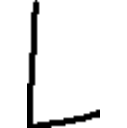

T


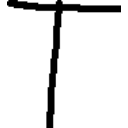

1


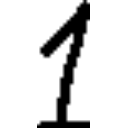

C


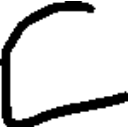

V


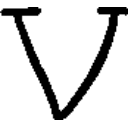

8


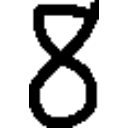

In [ ]:
check_models = []

for image_path in os.listdir(check_path):
  check_models.append(create_check_model(image_path))


for i, check_model in enumerate(check_models):
  closest = ("$", 9999)
  for tuple_ in upload_models:
    ans = tuple_[0]
    sum = 0.0
    for model in tuple_[1]:
      sum += distant(check_model, model)
    if (sum < closest[1]):
      closest = (ans, sum)
  image = cv2.imread(check_path + '/' + os.listdir(check_path)[i])
  print(closest[0])
  cv2_imshow(preprocess(image))